# Finding Heavy Traffic Indicators on I-94

## Introduction 

I-94 is an east–west Interstate Highway stretching from  Port Huron, Michigan to Billings, Montana.  It connects the Great Lakes and northern Great Plains regions of the United States. In this notebook we'll be looking to determine some heavy traffic indicators on I-94, including time of day and year and weather factors.   The [dataset](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume) was downloaded from the UCI Machine Learning Repository, as made available by John Hogue. According to the dataset documentation, all of the data is for westbound traffic, recorded at a staion approximatly halfway between Minneapolis and Saint Paul, Minnesota. Unfortunately this prevents us from making any assumptions about eastbound traffic. 

# First Look at the Data

We begin by importing libraries and getting our first look at the data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
%matplotlib inline

In [42]:
traffic = pd.read_csv('Metro_Interstate_Traffic_Volume.csv')

traffic.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [3]:
traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


We have 9 columns, all related to traffic volume, date/time/holiday and meteorological data.  The documentation gives us definitions for each of the columns:
- holiday: Categorical US National holidays plus regional holiday, Minnesota State Fair
- temp: Numeric Average temp in kelvin
- rain:_1h Numeric Amount in mm of rain that occurred in the hour
- snow_1h: Numeric Amount in mm of snow that occurred in the hour
- clouds_all: Numeric Percentage of cloud cover
- weather_main: Categorical Short textual description of the current weather
- weather_description: Categorical Longer textual description of the current weather
- date_time: Date and Hour of the data collected in local CST time
- traffic_volume: Numeric Hourly I-94 ATR 301 reported westbound traffic volume

Since the traffic volume is our main interest, we'll take a look at it first. 

In [50]:
traffic['traffic_volume'].describe()

count    48204.000000
mean      3259.818355
std       1986.860670
min          0.000000
25%       1193.000000
50%       3380.000000
75%       4933.000000
max       7280.000000
Name: traffic_volume, dtype: float64

Volume ranges from 0 to 7280 VPH with a mean of 3260.  Let's look at the distribution with a histogram.

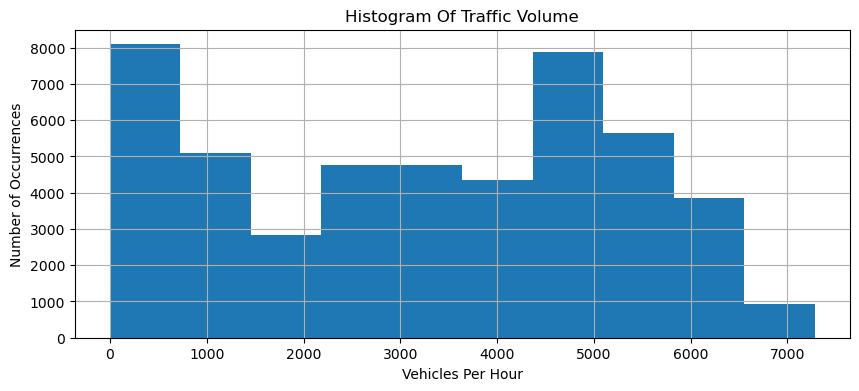

In [51]:
traffic.hist('traffic_volume',figsize = (10,4)) #blocks of approximately 100

plt.title('Histogram Of Traffic Volume')

plt.xlabel('Vehicles Per Hour')

plt.ylabel('Number of Occurrences')

plt.show()

We see that most of the values fall in 2 ranges.  There are approximately 8000 recordings each in the 0-500 and 4500-5000 vehicles per hour ranges.  Occasionally (about 1000 times), we see volumes up into the lower 7000 range. The default is 10 bins. This is a fairly high level view.  We can add more bins to get a more granular look at the distribution.  Since the max is 7280, using 73 bins will give us blocks of 100.

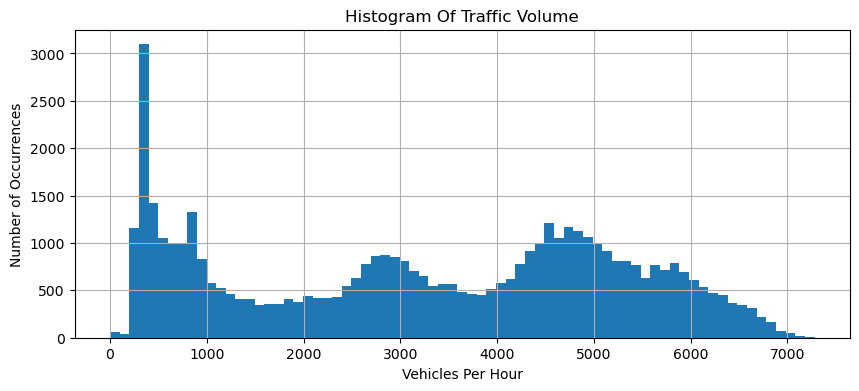

In [52]:
traffic.hist('traffic_volume',figsize = (10,4),bins = 73) #blocks of approximately 100

plt.title('Histogram Of Traffic Volume')

plt.xlabel('Vehicles Per Hour')

plt.ylabel('Number of Occurrences')

plt.show()

Now we see that the vast majority of recordings are in the 300-400 VPH, at over 3200 occurrences.  There are smaller peaks of about 800 and 1200 occurrences at around 2800 and 4700 VPH, respectively.

## Traffic Volume: Day vs. Night

Based on common traffic patterns, it is reasonable to hypothesize that the lowest volumes are at night and the highest ones occur during the day, possibly during rush hours and/or holidays. To test this hypothesis, we can divide the dataset into 2 parts, 12 hours each, from 7 A.M. to 7 P.M. (daytime) and 7 P.M. to 7 A.M. (night time).  This is just a starting point and may need editing based on our findings. 

In [54]:
# convert date_time to datetime dtype.
traffic['date_time'] = pd.to_datetime(traffic['date_time'])

day = traffic[(traffic['date_time'].dt.hour >= 7) &
                (traffic['date_time'].dt.hour < 19)].copy()
day

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.00,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.00,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.00,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.00,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.00,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918
...,...,...,...,...,...,...,...,...,...
48194,None,283.84,0.00,0.0,75,Rain,proximity shower rain,2018-09-30 15:00:00,4302
48195,None,283.84,0.00,0.0,75,Drizzle,light intensity drizzle,2018-09-30 15:00:00,4302
48196,None,284.38,0.00,0.0,75,Rain,light rain,2018-09-30 16:00:00,4283
48197,None,284.79,0.00,0.0,75,Clouds,broken clouds,2018-09-30 17:00:00,4132


In [55]:
night = traffic[(traffic['date_time'].dt.hour < 7) |
                (traffic['date_time'].dt.hour >= 19)].copy()
night

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
10,None,290.97,0.0,0.0,20,Clouds,few clouds,2012-10-02 19:00:00,3539
11,None,289.38,0.0,0.0,1,Clear,sky is clear,2012-10-02 20:00:00,2784
12,None,288.61,0.0,0.0,1,Clear,sky is clear,2012-10-02 21:00:00,2361
13,None,287.16,0.0,0.0,1,Clear,sky is clear,2012-10-02 22:00:00,1529
14,None,285.45,0.0,0.0,1,Clear,sky is clear,2012-10-02 23:00:00,963
...,...,...,...,...,...,...,...,...,...
48199,None,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543
48200,None,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781
48201,None,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159
48202,None,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450


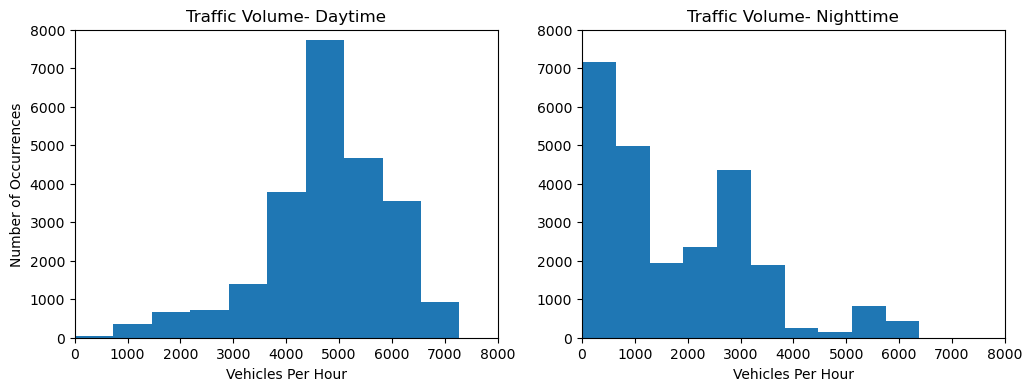

In [56]:
plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.title('Traffic Volume- Daytime')
plt.xlabel('Vehicles Per Hour')
plt.ylabel('Number of Occurrences')

plt.xlim(0,8000)
plt.ylim(0,8000)


plt.hist(day['traffic_volume'])

plt.subplot(1, 2, 2)
plt.ylim(0,8000)
plt.xlim(0,8000)
plt.hist(night['traffic_volume'])
plt.xlabel('Vehicles Per Hour')


plt.title('Traffic Volume- Nighttime')
plt.show()

It appears most of our daytime values center around 5000 vehicles per hour, while at nighttime they are much lower, with most of the counts falling between 0 and 4000 vehicles per hour. Since we are interested in determining the causes of high traffic volume, we may want to consider not using the night data.  We can look at the statistics of the day vs. the night data to help make that decision. 

In [11]:
day['traffic_volume'].describe()

count    23877.000000
mean      4762.047452
std       1174.546482
min          0.000000
25%       4252.000000
50%       4820.000000
75%       5559.000000
max       7280.000000
Name: traffic_volume, dtype: float64

In [12]:
night['traffic_volume'].describe()

count    24327.000000
mean      1785.377441
std       1441.951197
min          0.000000
25%        530.000000
50%       1287.000000
75%       2819.000000
max       6386.000000
Name: traffic_volume, dtype: float64

When we ran pd.describe on all of the data, we saw a median value of 3380.  We can now see that at night more than 75% of the values fall below that and during the day more than 75% are above it.  Based on this, we can choose to focus solely on the daytime data. 

## Time Indicators

Having narrowed down our data to focus on daytime hours, we can now look at what time and date factors might contribute to heavier traffic. We will look at how the parameters of month, day of the week and time of day influence the volume. 

### By Month

First we'll look at volume by month of the year.  We'll need to create a column for the month and then group by that column to get an average value.

In [47]:
day['month'] = day['date_time'].dt.month

by_month = day.groupby('month').mean(numeric_only = True)
by_month['traffic_volume']

month
1     4495.613727
2     4711.198394
3     4889.409560
4     4906.894305
5     4911.121609
6     4898.019566
7     4595.035744
8     4928.302035
9     4870.783145
10    4921.234922
11    4704.094319
12    4374.834566
Name: traffic_volume, dtype: float64

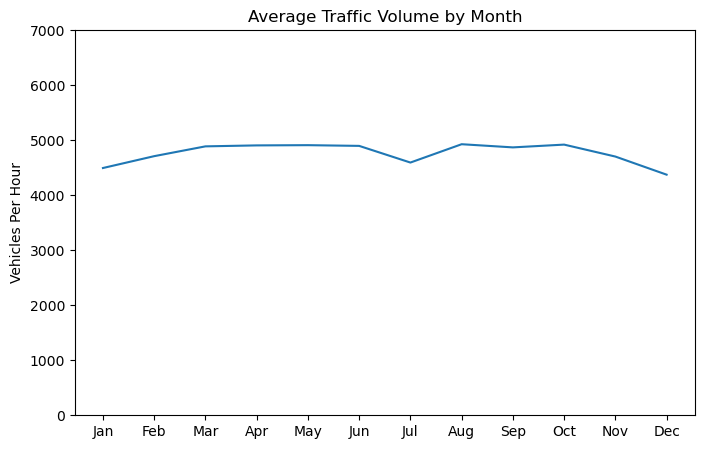

In [48]:
by_month['traffic_volume'].plot(figsize = (8,5))

plt.title('Average Traffic Volume by Month')
plt.xlabel('')
plt.xticks(range(1,13),labels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])

plt.ylabel('Vehicles Per Hour')
plt.ylim(0,7000)

plt.show()

### By Day of the Week

Traffic is lowest during the winter months, particularly Decenber and January, and peaks in the summer.  The one exception to this pattern is July, when it falls back near to but not quite the winter values. Now let's look at traffic by day of week.

In [15]:
day['dayofweek'] = day['date_time'].dt.dayofweek
by_dayofweek = day.groupby('dayofweek').mean(numeric_only = True)
by_dayofweek['traffic_volume']  # 0 is Monday, 6 is Sunday

dayofweek
0    4893.551286
1    5189.004782
2    5284.454282
3    5311.303730
4    5291.600829
5    3927.249558
6    3436.541789
Name: traffic_volume, dtype: float64

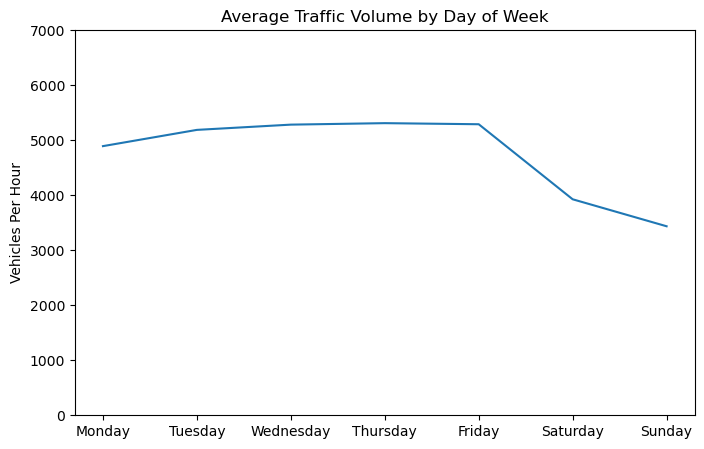

In [49]:
by_dayofweek['traffic_volume'].plot(figsize = (8,5))

plt.title('Average Traffic Volume by Day of Week')
plt.xlabel('')
plt.xticks(range(7),labels = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])

plt.ylabel('Vehicles Per Hour')
plt.ylim(0,7000)


plt.show()

### By Hour
The weekends, particularly Sunday have the lowest volumes.  There is also a small upward trend between Monday and Friday. Sunday is the slowest day of the week. 

Our last time indicator is hour.  As we just discovered, the weekends have lower volumes, so we'll want to split the weekdays and weekends 

In [17]:
#Create hour column 
day['hour'] = day['date_time'].dt.hour

#split off weekdays and group by day of week
business_days = day.copy()[day['dayofweek'] <= 4] # 4 == Friday
by_hour_business = business_days.groupby('hour').mean(numeric_only = True)

#split off weekends and group by day of week
weekend = day.copy()[day['dayofweek'] >= 5] # 5 == Saturday
by_hour_weekend = weekend.groupby('hour').mean(numeric_only = True)

#Show the hourly volume averages
print(by_hour_business['traffic_volume'])
print(by_hour_weekend['traffic_volume'])

hour
7     6030.413559
8     5503.497970
9     4895.269257
10    4378.419118
11    4633.419470
12    4855.382143
13    4859.180473
14    5152.995778
15    5592.897768
16    6189.473647
17    5784.827133
18    4434.209431
Name: traffic_volume, dtype: float64
hour
7     1589.365894
8     2338.578073
9     3111.623917
10    3686.632302
11    4044.154955
12    4372.482883
13    4362.296564
14    4358.543796
15    4342.456881
16    4339.693805
17    4151.919929
18    3811.792279
Name: traffic_volume, dtype: float64


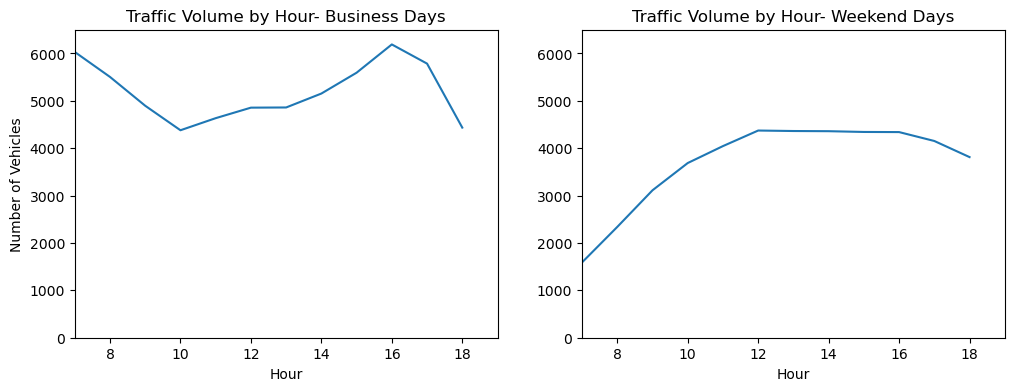

In [18]:

# Plot business days on plot 1,1 
plt.subplot(1, 2, 1)
by_hour_business['traffic_volume'].plot.line(figsize = (12,4))
plt.title('Traffic Volume by Hour- Business Days')
plt.xlabel('Hour')
plt.ylabel('Number of Vehicles')
plt.xlim(7,19)
plt.ylim(0,6500)


# Plot weekend days on plot 1,2
plt.subplot(1, 2, 2)
plt.title('Traffic Volume by Hour- Weekend Days')
by_hour_weekend['traffic_volume'].plot.line(figsize = (12,4))
plt.xlim(7,19)
plt.ylim(0,6500)
plt.xlabel('Hour')



plt.show()

The two charts show very different trends.  Business days have 2 peaks, A.K.A. Rush Hours at hours 7 and 16 (7 A.M. and 4 P.M.). The minimum volume is over 4000.  Weekend days on the other hand start around 1800 VPH, peak around 4000 VPH between hours 12 and 16 (Noon and 4. PM), before tapering off slightly to the end of the day. 

## Weather Indicators

   In addition to time, another factor in heavy traffic can be the weather.  Our dataset has numeric information on temperature, rain and snowfall, and cloud cover.  Since It's easier to find correlations in numerical data, we'll start with the numerical columns, using df.corr(). First, we need to fix a couple of data issues.  If we look at day.describe(), we'll see that the `temp` column ranges from 0 to 310.  Also, `rain_h` ranges from 0 to 9831 mm.

In [19]:
day.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,month,dayofweek,hour
count,23877.000000,23877.00000,23877.000000,23877.000000,23877.000000,23877.000000,23877.000000,23877.000000
mean,282.257596,0.53306,0.000253,53.122000,4762.047452,6.522218,2.983457,12.431419
std,13.298885,63.62932,0.008853,37.564588,1174.546482,3.407585,2.007363,3.473405
min,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,7.000000
25%,272.680000,0.00000,0.000000,5.000000,4252.000000,4.000000,1.000000,9.000000
50%,283.780000,0.00000,0.000000,75.000000,4820.000000,7.000000,3.000000,12.000000
75%,293.440000,0.00000,0.000000,90.000000,5559.000000,9.000000,5.000000,15.000000
max,310.070000,9831.30000,0.510000,100.000000,7280.000000,12.000000,6.000000,18.000000


Since `temp` is in Kelvin, 0 is absolute zero, or (−273.15 °C; −459.67 °F). Nowhere on Earth is that cold. The `rain_1h` max of 9831 mm is about 32 *feet*.  Ten inches in *day* is a lot, so this value must be a mistake as well. Let's take a closer look at these columns.

In [20]:
day['temp'].value_counts().sort_index()

0.00      2
243.39    1
243.62    1
245.70    2
246.15    2
         ..
308.87    1
308.95    1
309.08    1
309.29    1
310.07    1
Name: temp, Length: 5111, dtype: int64

In [21]:
day['rain_1h'].value_counts().sort_index()

0.00       22106
0.25         475
0.26           2
0.27           5
0.28          15
           ...  
20.24          3
21.42          3
31.75          1
44.45          1
9831.30        1
Name: rain_1h, Length: 244, dtype: int64

There are 2 rows with 0 K and one with 9831.30 mm of rain per hour.  We'll filter them out before continuing.

In [22]:
day_cleaned = day[(day['temp'] > 240) & (day['rain_1h'] < 45)]


In [23]:
day_cleaned.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,month,dayofweek,hour
count,23874.000000,23874.000000,23874.000000,23874.000000,23874.000000,23874.000000,23874.000000,23874.000000
mean,282.280410,0.121328,0.000253,53.125534,4762.303761,6.522577,2.983329,12.431641
std,13.045731,0.880427,0.008854,37.563534,1174.181562,3.407547,2.007206,3.473201
min,243.390000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,7.000000
25%,272.680000,0.000000,0.000000,5.000000,4253.000000,4.000000,1.000000,9.000000
50%,283.780000,0.000000,0.000000,75.000000,4820.000000,7.000000,3.000000,12.000000
75%,293.440000,0.000000,0.000000,90.000000,5559.000000,9.000000,5.000000,15.000000
max,310.070000,44.450000,0.510000,100.000000,7280.000000,12.000000,6.000000,18.000000


Our outliers are gone. Let's make sure we only removed 3 rows.

In [24]:
# make sure 3 columns were removed.  23877-3 = 23874
print(day.shape)
print(day_cleaned.shape)

(23877, 12)
(23874, 12)


With our bad data taken care of, we can move on to looking for correlations in the numeric weather columns. 

In [25]:
# Remove time and categorical columns
numeric_weather_cols = ['temp', 'rain_1h', 'snow_1h', 'clouds_all','traffic_volume']
day_cleaned[numeric_weather_cols].corr(numeric_only = True)['traffic_volume']

temp              0.125502
rain_1h          -0.040676
snow_1h           0.001260
clouds_all       -0.033311
traffic_volume    1.000000
Name: traffic_volume, dtype: float64

None of the columns show a strong correlation, negative or positive.  The strongest is temperature with +0.12. We'll take a closer look by creating a scatter plot of temperature vs. traffic volume.

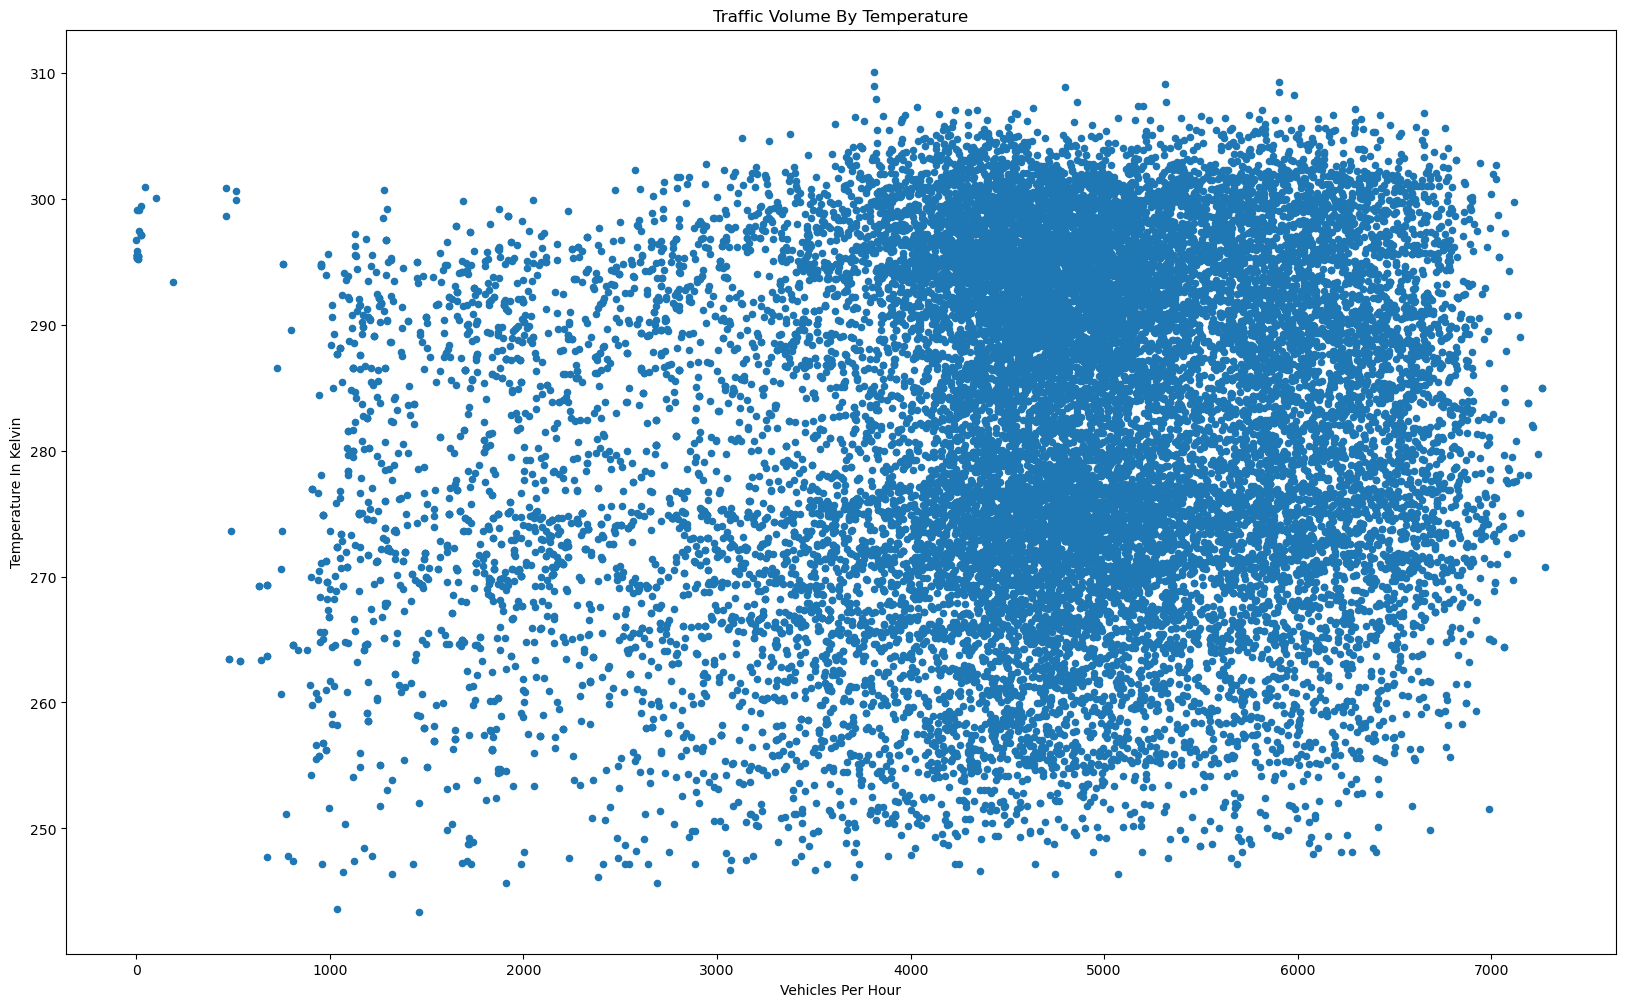

In [26]:
# plot traffic_volume by temperature
day_cleaned.plot.scatter('traffic_volume','temp',figsize = (20,12)) # large graph to show more detail
plt.title('Traffic Volume By Temperature')
plt.xlabel('Vehicles Per Hour')
plt.ylabel('Temperature In Kelvin')

plt.show()

Again, we see a small positive correlation, but it appears insignificant. So far this is the only indication that weather is an indicator. 

Since none of the numerical columns yielded useful information, we'll turn to the categorical ones, `weather_main` and `weather_description`.  First, let's look at the description and value counts of these two columns.

In [27]:
day_cleaned['weather_main'].describe()

count      23874
unique        11
top       Clouds
freq        8702
Name: weather_main, dtype: object

In [28]:
day_cleaned['weather_main'].value_counts()

Clouds          8702
Clear           5742
Rain            2840
Mist            2593
Snow            1454
Drizzle          883
Haze             834
Thunderstorm     451
Fog              362
Smoke             12
Squall             1
Name: weather_main, dtype: int64

In [29]:
day_cleaned['weather_description'].describe()

count            23874
unique              38
top       sky is clear
freq              4890
Name: weather_description, dtype: object

In [30]:
day_cleaned['weather_description'].value_counts()

sky is clear                           4890
broken clouds                          2793
mist                                   2593
overcast clouds                        2585
scattered clouds                       2181
light rain                             1707
few clouds                             1143
light snow                              978
Sky is Clear                            852
haze                                    834
moderate rain                           785
light intensity drizzle                 573
fog                                     362
heavy snow                              320
proximity thunderstorm                  303
drizzle                                 278
heavy intensity rain                    219
snow                                    137
proximity shower rain                   111
thunderstorm                             48
heavy intensity drizzle                  29
thunderstorm with heavy rain             25
thunderstorm with light rain    

Both columns have a manageable number of unique values.  We can calculate the average traffic volume for each value to see if any correlate with traffic volume. 

In [31]:
by_weather_main = day_cleaned.groupby('weather_main').mean(numeric_only = True).sort_values(by = 'traffic_volume')
by_weather_description = day_cleaned.groupby('weather_description').mean(numeric_only = True).sort_values(by = 'traffic_volume')

In [32]:
by_weather_main

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,month,dayofweek,hour
weather_main,,,,,,,,
Squall,296.730000,1.020000,0.000000,75.000000,4211.000000,7.000000,2.000000,14.000000
Fog,277.579641,0.163840,0.001409,65.477901,4372.491713,6.646409,2.798343,10.325967
Snow,267.984505,0.014017,0.001768,80.501376,4396.321183,6.374828,2.750344,12.153370
Smoke,292.405833,0.878333,0.000000,53.333333,4564.583333,6.833333,2.416667,13.166667
Haze,275.319353,0.040036,0.000000,64.000000,4609.893285,5.832134,2.754197,12.467626
Mist,279.420825,0.249992,0.000825,74.961435,4623.976475,6.734285,2.895102,11.078288
Thunderstorm,293.364678,1.146475,0.000000,75.184035,4648.212860,7.108647,2.955654,12.694013
Clear,283.910932,0.000000,0.000000,1.670846,4779.622257,6.492163,3.137931,12.405956
Rain,287.084312,0.512616,0.000292,75.870423,4815.315141,6.773944,2.915493,12.640845


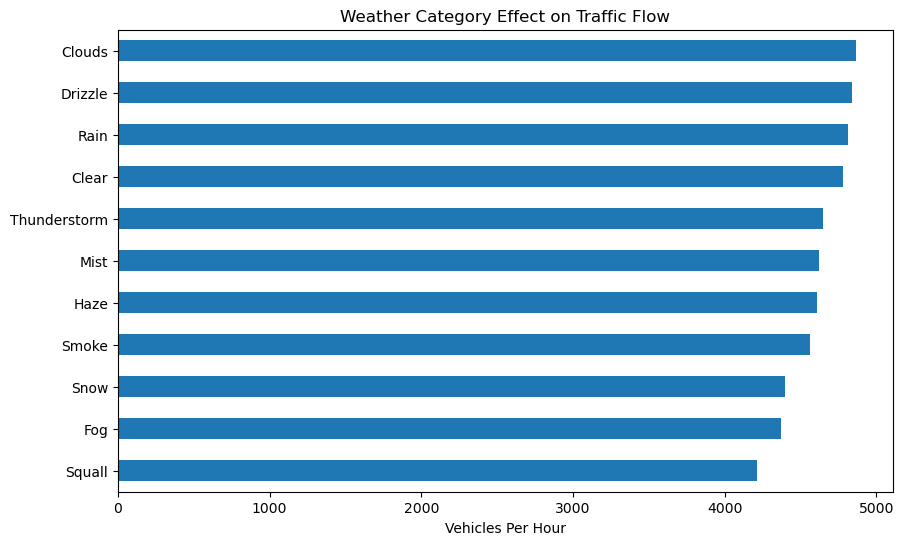

In [33]:
plt.figure(figsize = (10,6))

by_weather_main['traffic_volume'].plot.barh()

plt.title('Weather Category Effect on Traffic Flow')

plt.ylabel('')

plt.xlabel('Vehicles Per Hour')

plt.show()

Nothing stands out here.  Regardless of the weather type, volume averages between approximately 4500 and 5000 vehicles per hour. Let's look at `weather_description`

In [34]:
fig = plt.figure(figsize=(20, 10))

<Figure size 2000x1000 with 0 Axes>

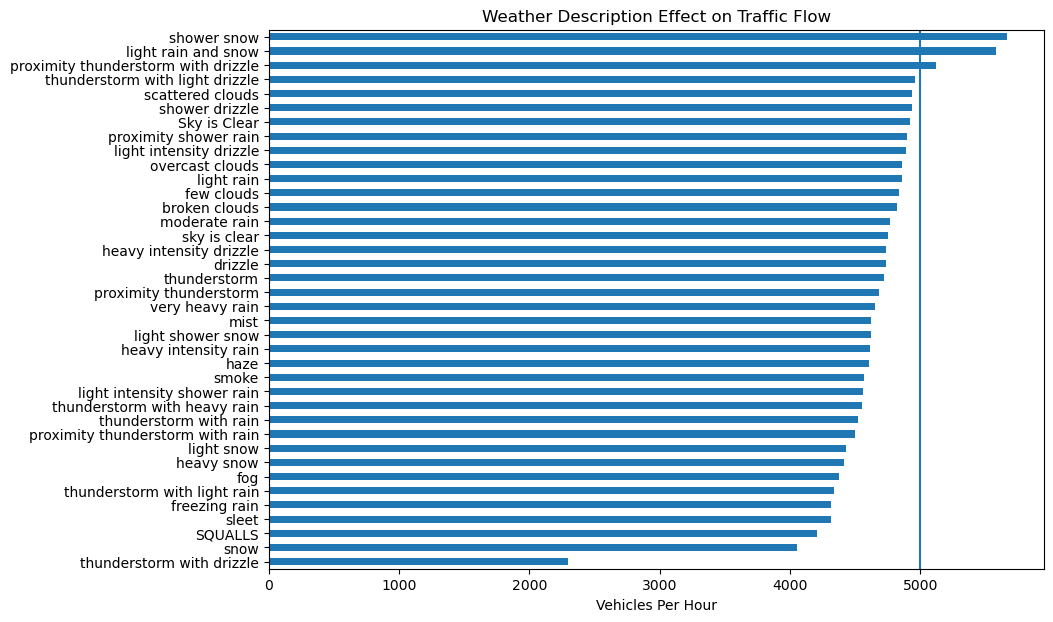

In [35]:

by_weather_description['traffic_volume'].plot.barh(figsize=(10,7))

plt.title("Weather Description Effect on Traffic Flow")

plt.xlabel("Vehicles Per Hour")
plt.ylabel("")
plt.axvline(5000)

plt.show()

Now we have some interesting results.  While most of the averages fall in the 4,000-5,000 VPH  range, there are three that average above 5.000: 
- shower snow 
- light rain and snow
- proximity thunderstorm with drizzle

There is also one category that is very low, around 2500 VPH:
- thunderstorm with drizzle

## Conclusion

In this notebook, we have analyzed traffic flow indicators along westbound I-94 between Minneapolis and Saint Paul, Minnesota for dates between 2012 and 2017.  We first looked at time/date indicators and found that traffic is heavier during the day, especially on business days, which range between 4000 - 6000 VPH. Weekday Rush Hour traffic peaks at 7 A.M. and 4 P.M. at around 6000 VPH. Weekends see much lower volume, ranging from 1500 - 4000 VPH.  Traffic also tends to be heavier in warmer months, with the slowest months being December and January. There is a slight dip in volume during July, which might bear further investigation.

We then turned to weather indicators.  None of the numerical indicators of `temp`,`rain_1h`, `snow_1h`, or `clouds_all` showed a strong correlation with `traffic_volume`, with temperature being the highest at +0.13.  Finally we examined the categorical columns of `weather main` and `weather description`.  As the broader category, `weather description` yielded no interesting information; all of the averages fell between 4000 and 5000 VPH.  The More detailed `weather description` was the same except in 4 categories. Shower snow, light rain and snow, and proximity thunderstorm with drizzle all had averages above 5000 VPH, while thunderstorm with drizzle had an average below 2500. 

Armed with this data and insights, we might be able to make recommendations to the local transportation departments that could help them plan the best times for road construction or develop strategies for how to prevent or mitigate overcrowded conditions during peak traffic times. 